In [1]:
!python -V

Python 3.12.7


In [38]:
import pickle

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.feature_extraction import DictVectorizer

In [3]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import root_mean_squared_error

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")       #where to save tracking info (local path)
mlflow.set_experiment("second_experiment") #setting the experiment name. Will be created if not already available

2025/03/10 19:28:27 INFO mlflow.tracking.fluent: Experiment with name 'second_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/02-experiment-tracking/mlruns/1', creation_time=1741613307338, experiment_id='1', last_update_time=1741613307338, lifecycle_stage='active', name='second_experiment', tags={}>

In [5]:
df=pd.read_parquet('./data/green_tripdata_2021-01.parquet')
print(df.shape)
df.head()

(76518, 20)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [7]:
display(df.trip_type.value_counts())
print('-'*40)
display(df.trip_type.value_counts(normalize=True))

trip_type
1.0    39233
2.0     1238
Name: count, dtype: int64

----------------------------------------


trip_type
1.0    0.96941
2.0    0.03059
Name: proportion, dtype: float64

In [8]:
#getting trip duration
df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
df.duration=df.duration.apply(lambda td: td.total_seconds()/60)

In [9]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [10]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [11]:
#getting ride pct with certain filter
((df.duration>=1) & (df.duration<=60)).mean()

np.float64(0.9658903787344154)

- 96.5% rides are in this filter

In [12]:
df=df[((df.duration>=1) & (df.duration<=60))]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


### Experiment 1

In [13]:
categorical=['PULocationID','DOLocationID']
numerical=['trip_distance']

In [14]:
df[categorical]=df[categorical].astype(str)  #converting to string

In [15]:
train_dict=df[categorical+numerical].to_dict(orient='records')
train_dict[:10]

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [16]:
dv=DictVectorizer()
X_train= dv.fit_transform(train_dict)

In [17]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 221724 stored elements and shape (73908, 507)>

In [18]:
dv.feature_names_ #after OHE (One Hot Encoding)

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [19]:
target='duration'
y_train=df[target].values
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ], shape=(73908,))

In [20]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [21]:
y_pred=lr.predict(X_train)

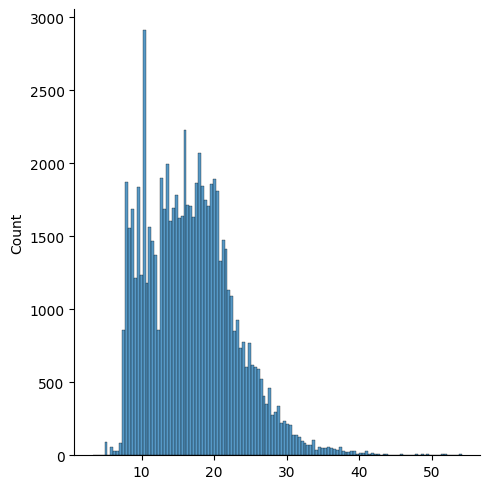

In [22]:
sns.displot(y_pred,label='prediction')


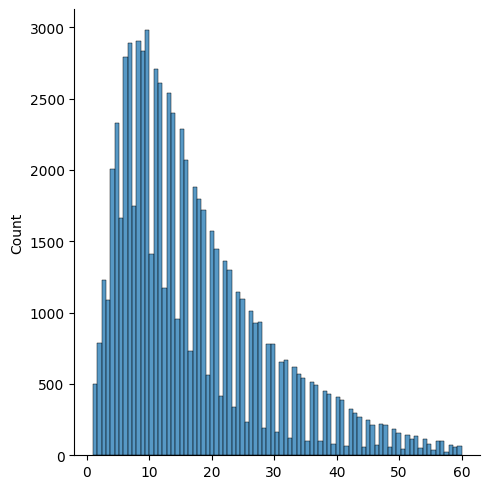

In [23]:
sns.displot(y_train,label='actual')


In [24]:
root_mean_squared_error(y_train,y_pred) #calculate RMSE

9.827368941909366

In [25]:
def read_dataframe(filename):
    df=pd.read_parquet(filename)

    #getting trip duration
    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda td: td.total_seconds()/60)

    #filtering
    df=df[((df.duration>=1) & (df.duration<=60))]

    categorical=['PULocationID','DOLocationID']
    numerical=['trip_distance']

    df[categorical]=df[categorical].astype(str)  #converting to string

    return df

In [26]:
df_train=read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val=read_dataframe('./data/green_tripdata_2021-02.parquet')
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [27]:
len(df_train),len(df_val)

(73908, 61921)

In [28]:
dv=DictVectorizer()

train_dict=df_train[categorical+numerical].to_dict(orient='records')
X_train= dv.fit_transform(train_dict)

val_dict=df_val[categorical+numerical].to_dict(orient='records')
X_val= dv.transform(val_dict)


target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [29]:

lr=LinearRegression()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)


root_mean_squared_error(y_val,y_pred) #calculate RMSE

10.496651120494061

In [30]:
lr=Lasso()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)

root_mean_squared_error(y_val,y_pred) #calculate RMSE

12.212583224318818

In [31]:
#model tracking with MLFlow
with mlflow.start_run():
    mlflow.set_tag("developer","mahmud")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")


    # alpha_var=0.01
    # alpha_var=0.001
    alpha_var=0.1
    mlflow.log_param("alpha",alpha_var)

    lr=Lasso(alpha=alpha_var)
    lr.fit(X_train,y_train)

    y_pred=lr.predict(X_val)

    rmse=root_mean_squared_error(y_val,y_pred) #calculate RMSE
    mlflow.log_metric("rmse",rmse)

#### Hyper parameter Tuning

In [32]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope 


In [33]:
train=xgb.DMatrix(X_train,label=y_train)
valid=xgb.DMatrix(X_val,label=y_val)

In [34]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster=xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds=50
        )

        y_pred=booster.predict(valid)
        rmse=root_mean_squared_error(y_val,y_pred)
        mlflow.log_metric("rmse",rmse)

    return {'loss':rmse, 'status':STATUS_OK}

In [35]:
search_space={
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1))   #hp.quniform(label, low, high, q); round(uniform(low, high) / q) * q
    , 'learning_rate': hp.loguniform('learning_rate',-3,0)  #hp.loguniform(label, low, high); [exp(low), exp(high)]; exp(-3),exp(0) --> [0.05,1]
    , 'reg_alpha': hp.loguniform('reg_alpha',-5,-1)  #exp(-5),exp(-1) --> [0.007,0.368]
    , 'reg_lambda': hp.loguniform('reg_lambda',-6,-1)   #exp(-6),exp(-1) --> [0.002,0.368]
    , 'min_child_weight': hp.loguniform('min_child_weight',-1,3) #exp(-1),exp(3) --> [0.368,20]
    , 'objective': 'reg:linear'
    , 'seed': 42
}

best_result=fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:11.56400                          
[1]	validation-rmse:10.97894                          
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.45346                          
[3]	validation-rmse:9.98173                           
[4]	validation-rmse:9.55870                           
[5]	validation-rmse:9.18075                           
[6]	validation-rmse:8.84359                           
[7]	validation-rmse:8.54379                           
[8]	validation-rmse:8.27879                           
[9]	validation-rmse:8.04283                           
[10]	validation-rmse:7.83623                          
[11]	validation-rmse:7.65310                          
[12]	validation-rmse:7.49102                          
[13]	validation-rmse:7.35020                          
[14]	validation-rmse:7.22318                          
[15]	validation-rmse:7.11238                          
[16]	validation-rmse:7.01657                          
[17]	validation-rmse:6.93288                          
[18]	validation-rmse:6.85898                          
[19]	validation-rmse:6.79485                          
[20]	valid

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.16230                                                   
[2]	validation-rmse:10.70495                                                   
[3]	validation-rmse:10.28575                                                   
[4]	validation-rmse:9.90611                                                    
[5]	validation-rmse:9.55864                                                    
[6]	validation-rmse:9.24299                                                    
[7]	validation-rmse:8.95733                                                    
[8]	validation-rmse:8.69824                                                    
[9]	validation-rmse:8.46466                                                    
[10]	validation-rmse:8.25401                                                   
[11]	validation-rmse:8.06308                                                   
[12]	validation-rmse:7.89204                                                   
[13]	validation-rmse:7.73779            

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.92785                                                    
[2]	validation-rmse:8.02918                                                    
[3]	validation-rmse:7.45154                                                    
[4]	validation-rmse:7.08186                                                    
[5]	validation-rmse:6.85527                                                    
[6]	validation-rmse:6.70753                                                    
[7]	validation-rmse:6.61551                                                    
[8]	validation-rmse:6.55602                                                    
[9]	validation-rmse:6.52381                                                    
[10]	validation-rmse:6.49875                                                   
[11]	validation-rmse:6.48339                                                   
[12]	validation-rmse:6.47100                                                   
[13]	validation-rmse:6.46878            

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.80549                                                    
[4]	validation-rmse:6.81853                                                    
[5]	validation-rmse:6.85776                                                    
[6]	validation-rmse:6.88803                                                    
[7]	validation-rmse:6.91556                                                    
[8]	validation-rmse:6.94560                                                    
[9]	validation-rmse:6.95676                                                    
[10]	validation-rmse:6.98972                                                   
[11]	validation-rmse:7.02274                                                   
[12]	validation-rmse:7.04072                                                   
[13]	validation-rmse:7.05242                                                   
[14]	validation-rmse:7.08832                                                   
[15]	validation-rmse:7.10427            

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.78708                                                   
[2]	validation-rmse:10.19966                                                   
[3]	validation-rmse:9.68496                                                    
[4]	validation-rmse:9.23378                                                    
[5]	validation-rmse:8.84042                                                    
[6]	validation-rmse:8.50024                                                    
[7]	validation-rmse:8.20646                                                    
[8]	validation-rmse:7.95252                                                    
[9]	validation-rmse:7.73259                                                    
[10]	validation-rmse:7.54051                                                   
[11]	validation-rmse:7.37759                                                   
[12]	validation-rmse:7.24078                                                   
[13]	validation-rmse:7.12226            

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.67174                                                   
[3]	validation-rmse:10.24732                                                   
[4]	validation-rmse:9.86101                                                    
[5]	validation-rmse:9.50917                                                    
[6]	validation-rmse:9.19046                                                    
[7]	validation-rmse:8.90298                                                    
[8]	validation-rmse:8.64219                                                    
[9]	validation-rmse:8.40650                                                    
[10]	validation-rmse:8.19318                                                   
[11]	validation-rmse:7.99998                                                   
[12]	validation-rmse:7.82540                                                   
[13]	validation-rmse:7.66865                                                   
[14]	validation-rmse:7.52713            

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:6.29288                                                    
[8]	validation-rmse:6.28549                                                    
[9]	validation-rmse:6.27624                                                    
[10]	validation-rmse:6.27743                                                   
[11]	validation-rmse:6.27435                                                   
[12]	validation-rmse:6.27001                                                   
[13]	validation-rmse:6.26752                                                   
[14]	validation-rmse:6.26562                                                   
[15]	validation-rmse:6.26623                                                   
[16]	validation-rmse:6.26652                                                   
[17]	validation-rmse:6.26490                                                   
[18]	validation-rmse:6.26623                                                   
[19]	validation-rmse:6.26691            

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.72334                                                   
[4]	validation-rmse:6.77064                                                   
[5]	validation-rmse:6.82738                                                   
[6]	validation-rmse:6.86337                                                   
[7]	validation-rmse:6.88004                                                   
[8]	validation-rmse:6.91367                                                   
[9]	validation-rmse:6.92649                                                   
[10]	validation-rmse:6.94745                                                  
[11]	validation-rmse:6.96749                                                  
[12]	validation-rmse:6.98199                                                  
[13]	validation-rmse:6.99262                                                  
[14]	validation-rmse:7.01558                                                  
[15]	validation-rmse:7.02371                        

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[9]	validation-rmse:6.36522                                                   
[10]	validation-rmse:6.36380                                                  
[11]	validation-rmse:6.36085                                                  
[12]	validation-rmse:6.36244                                                  
[13]	validation-rmse:6.35962                                                  
[14]	validation-rmse:6.35472                                                  
[15]	validation-rmse:6.35005                                                  
[16]	validation-rmse:6.35360                                                  
[17]	validation-rmse:6.35284                                                  
[18]	validation-rmse:6.35630                                                  
[19]	validation-rmse:6.35819                                                  
[20]	validation-rmse:6.35922                                                  
[21]	validation-rmse:6.36953                        

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:37] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.44171                                                   
[4]	validation-rmse:6.38462                                                   
[5]	validation-rmse:6.36098                                                   
[6]	validation-rmse:6.35649                                                   
[7]	validation-rmse:6.35990                                                   
[8]	validation-rmse:6.36075                                                   
[9]	validation-rmse:6.36208                                                   
[10]	validation-rmse:6.36636                                                  
[11]	validation-rmse:6.36610                                                  
[12]	validation-rmse:6.37296                                                  
[13]	validation-rmse:6.37877                                                  
[14]	validation-rmse:6.38368                                                  
[15]	validation-rmse:6.39130                        

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.50663                                                    
[7]	validation-rmse:6.42904                                                    
[8]	validation-rmse:6.36776                                                    
[9]	validation-rmse:6.32829                                                    
[10]	validation-rmse:6.30111                                                   
[11]	validation-rmse:6.28312                                                   
[12]	validation-rmse:6.26783                                                   
[13]	validation-rmse:6.25520                                                   
[14]	validation-rmse:6.24388                                                   
[15]	validation-rmse:6.23608                                                   
[16]	validation-rmse:6.23108                                                   
[17]	validation-rmse:6.22800                                                   
[18]	validation-rmse:6.22358            

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.80665                                                     
[6]	validation-rmse:6.63962                                                     
[7]	validation-rmse:6.53033                                                     
[8]	validation-rmse:6.45684                                                     
[9]	validation-rmse:6.39941                                                     
[10]	validation-rmse:6.35442                                                    
[11]	validation-rmse:6.32326                                                    
[12]	validation-rmse:6.30005                                                    
[13]	validation-rmse:6.28235                                                    
[14]	validation-rmse:6.26912                                                    
[15]	validation-rmse:6.25713                                                    
[16]	validation-rmse:6.24765                                                    
[17]	validation-rmse:6.23844

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:8.50074                                                    
[13]	validation-rmse:8.34041                                                    
[14]	validation-rmse:8.19151                                                    
[15]	validation-rmse:8.05426                                                    
[16]	validation-rmse:7.92799                                                    
[17]	validation-rmse:7.81297                                                    
[18]	validation-rmse:7.70571                                                    
[19]	validation-rmse:7.60838                                                    
[20]	validation-rmse:7.51740                                                    
[21]	validation-rmse:7.43312                                                    
[22]	validation-rmse:7.35634                                                    
[23]	validation-rmse:7.28551                                                    
[24]	validation-rmse:7.21988

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.79598                                                     
[2]	validation-rmse:6.72183                                                     
[3]	validation-rmse:6.73988                                                     
[4]	validation-rmse:6.74873                                                     
[5]	validation-rmse:6.76235                                                     
[6]	validation-rmse:6.76598                                                     
[7]	validation-rmse:6.77815                                                     
[8]	validation-rmse:6.78223                                                     
[9]	validation-rmse:6.79435                                                     
[10]	validation-rmse:6.80361                                                    
[11]	validation-rmse:6.81880                                                    
[12]	validation-rmse:6.82674                                                    
[13]	validation-rmse:6.83322

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[11]	validation-rmse:6.25897                                                    
[12]	validation-rmse:6.25379                                                    
[13]	validation-rmse:6.24772                                                    
[14]	validation-rmse:6.24690                                                    
[15]	validation-rmse:6.24687                                                    
[16]	validation-rmse:6.24493                                                    
[17]	validation-rmse:6.24172                                                    
[18]	validation-rmse:6.24142                                                    
[19]	validation-rmse:6.24288                                                    
[20]	validation-rmse:6.24121                                                    
[21]	validation-rmse:6.24006                                                    
[22]	validation-rmse:6.23882                                                    
[23]	validation-rmse:6.23910

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.38785                                                     
[5]	validation-rmse:6.39223                                                     
[6]	validation-rmse:6.39379                                                     
[7]	validation-rmse:6.39752                                                     
[8]	validation-rmse:6.39653                                                     
[9]	validation-rmse:6.40097                                                     
[10]	validation-rmse:6.40722                                                    
[11]	validation-rmse:6.40708                                                    
[12]	validation-rmse:6.41353                                                    
[13]	validation-rmse:6.42447                                                    
[14]	validation-rmse:6.43007                                                    
[15]	validation-rmse:6.43441                                                    
[16]	validation-rmse:6.43431

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:30:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:9.16602                                                     
[6]	validation-rmse:8.83126                                                     
[7]	validation-rmse:8.53232                                                     
[8]	validation-rmse:8.27030                                                     
[9]	validation-rmse:8.03793                                                     
[10]	validation-rmse:7.83242                                                    
[11]	validation-rmse:7.65306                                                    
[12]	validation-rmse:7.49225                                                    
[13]	validation-rmse:7.35149                                                    
[14]	validation-rmse:7.22841                                                    
[15]	validation-rmse:7.11909                                                    
[16]	validation-rmse:7.02490                                                    
[17]	validation-rmse:6.94157

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:6.90493                                                    
[30]	validation-rmse:6.87616                                                    
[31]	validation-rmse:6.84881                                                    
[32]	validation-rmse:6.82346                                                    
[33]	validation-rmse:6.80106                                                    
[34]	validation-rmse:6.77866                                                    
[35]	validation-rmse:6.76028                                                    
[36]	validation-rmse:6.74255                                                    
[37]	validation-rmse:6.72666                                                    
[38]	validation-rmse:6.71101                                                    
[39]	validation-rmse:6.69674                                                    
[40]	validation-rmse:6.68408                                                    
[41]	validation-rmse:6.67238

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.45152                                                     
[3]	validation-rmse:7.81796                                                     
[4]	validation-rmse:7.37075                                                     
[5]	validation-rmse:7.05446                                                     
[6]	validation-rmse:6.83490                                                     
[7]	validation-rmse:6.69048                                                     
[8]	validation-rmse:6.58619                                                     
[9]	validation-rmse:6.51438                                                     
[10]	validation-rmse:6.46174                                                    
[11]	validation-rmse:6.42534                                                    
[12]	validation-rmse:6.40113                                                    
[13]	validation-rmse:6.38515                                                    
[14]	validation-rmse:6.37075

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.43777                                                     
[4]	validation-rmse:7.94346                                                     
[5]	validation-rmse:7.55655                                                     
[6]	validation-rmse:7.26245                                                     
[7]	validation-rmse:7.03476                                                     
[8]	validation-rmse:6.86375                                                     
[9]	validation-rmse:6.73109                                                     
[10]	validation-rmse:6.62970                                                    
[11]	validation-rmse:6.55199                                                    
[12]	validation-rmse:6.49153                                                    
[13]	validation-rmse:6.44316                                                    
[14]	validation-rmse:6.40542                                                    
[15]	validation-rmse:6.37548

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:7.11012                                                    
[32]	validation-rmse:7.07584                                                    
[33]	validation-rmse:7.04472                                                    
[34]	validation-rmse:7.01674                                                    
[35]	validation-rmse:6.99040                                                    
[36]	validation-rmse:6.96567                                                    
[37]	validation-rmse:6.94325                                                    
[38]	validation-rmse:6.92197                                                    
[39]	validation-rmse:6.90195                                                    
[40]	validation-rmse:6.88334                                                    
[41]	validation-rmse:6.86628                                                    
[42]	validation-rmse:6.84923                                                    
[43]	validation-rmse:6.83483

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[27]	validation-rmse:6.64684
[28]	validation-rmse:6.63802                                                    
[29]	validation-rmse:6.62813                                                    
[30]	validation-rmse:6.62002                                                    
[31]	validation-rmse:6.61268                                                    
[32]	validation-rmse:6.60592                                                    
[33]	validation-rmse:6.59893                                                    
[34]	validation-rmse:6.59307                                                    
[35]	validation-rmse:6.58911                                                    
[36]	validation-rmse:6.58354                                                    
[37]	validation-rmse:6.57771                                                    
[38]	validation-rmse:6.57423                                                    
[39]	validation-rmse:6.56880                                                    

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:6.68586                                                    
[30]	validation-rmse:6.67742                                                    
[31]	validation-rmse:6.66981                                                    
[32]	validation-rmse:6.66305                                                    
[33]	validation-rmse:6.65568                                                    
[34]	validation-rmse:6.65048                                                    
[35]	validation-rmse:6.64611                                                    
[36]	validation-rmse:6.64146                                                    
[37]	validation-rmse:6.63637                                                    
[38]	validation-rmse:6.63048                                                    
[39]	validation-rmse:6.62490                                                    
[40]	validation-rmse:6.62154                                                    
[41]	validation-rmse:6.61822

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:8.41213                                                     
[6]	validation-rmse:8.07414                                                     
[7]	validation-rmse:7.79117                                                     
[8]	validation-rmse:7.55722                                                     
[9]	validation-rmse:7.35880                                                     
[10]	validation-rmse:7.19688                                                    
[11]	validation-rmse:7.05941                                                    
[12]	validation-rmse:6.94561                                                    
[13]	validation-rmse:6.85085                                                    
[14]	validation-rmse:6.77066                                                    
[15]	validation-rmse:6.70391                                                    
[16]	validation-rmse:6.64530                                                    
[17]	validation-rmse:6.59656

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:6.30389                                                    
[20]	validation-rmse:6.29978                                                    
[21]	validation-rmse:6.29091                                                    
[22]	validation-rmse:6.28719                                                    
[23]	validation-rmse:6.28389                                                    
[24]	validation-rmse:6.27781                                                    
[25]	validation-rmse:6.27130                                                    
[26]	validation-rmse:6.26744                                                    
[27]	validation-rmse:6.26368                                                    
[28]	validation-rmse:6.26228                                                    
[29]	validation-rmse:6.25864                                                    
[30]	validation-rmse:6.25579                                                    
[31]	validation-rmse:6.24970

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.46274                                                     
[4]	validation-rmse:7.97411                                                     
[5]	validation-rmse:7.59860                                                     
[6]	validation-rmse:7.30646                                                     
[7]	validation-rmse:7.08309                                                     
[8]	validation-rmse:6.90877                                                     
[9]	validation-rmse:6.78043                                                     
[10]	validation-rmse:6.67914                                                    
[11]	validation-rmse:6.60165                                                    
[12]	validation-rmse:6.53768                                                    
[13]	validation-rmse:6.48759                                                    
[14]	validation-rmse:6.44841                                                    
[15]	validation-rmse:6.41770

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:6.69064                                                    
[19]	validation-rmse:6.65296                                                    
[20]	validation-rmse:6.62120                                                    
[21]	validation-rmse:6.59234                                                    
[22]	validation-rmse:6.56991                                                    
[23]	validation-rmse:6.54859                                                    
[24]	validation-rmse:6.53072                                                    
[25]	validation-rmse:6.51488                                                    
[26]	validation-rmse:6.49920                                                    
[27]	validation-rmse:6.48592                                                    
[28]	validation-rmse:6.47325                                                    
[29]	validation-rmse:6.46308                                                    
[30]	validation-rmse:6.45296

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:8.01843                                                     
[5]	validation-rmse:7.62595                                                     
[6]	validation-rmse:7.32566                                                     
[7]	validation-rmse:7.09459                                                     
[8]	validation-rmse:6.91568                                                     
[9]	validation-rmse:6.77562                                                     
[10]	validation-rmse:6.66679                                                    
[11]	validation-rmse:6.58422                                                    
[12]	validation-rmse:6.51799                                                    
[13]	validation-rmse:6.46787                                                    
[14]	validation-rmse:6.42519                                                    
[15]	validation-rmse:6.39163                                                    
[16]	validation-rmse:6.36545

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:9.23266                                                     
[5]	validation-rmse:8.84020                                                     
[6]	validation-rmse:8.49695                                                     
[7]	validation-rmse:8.20331                                                     
[8]	validation-rmse:7.94661                                                     
[9]	validation-rmse:7.72484                                                     
[10]	validation-rmse:7.53436                                                    
[11]	validation-rmse:7.36911                                                    
[12]	validation-rmse:7.22808                                                    
[13]	validation-rmse:7.10358                                                    
[14]	validation-rmse:6.99830                                                    
[15]	validation-rmse:6.90951                                                    
[16]	validation-rmse:6.83321

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[42]	validation-rmse:6.79183                                                    
[43]	validation-rmse:6.78257                                                    
[44]	validation-rmse:6.77322                                                    
[45]	validation-rmse:6.76475                                                    
[46]	validation-rmse:6.75694                                                    
[47]	validation-rmse:6.74997                                                    
[48]	validation-rmse:6.74310                                                    
[49]	validation-rmse:6.73575                                                    
[50]	validation-rmse:6.73059                                                    
[51]	validation-rmse:6.72375                                                    
[52]	validation-rmse:6.71781                                                    
[53]	validation-rmse:6.71208                                                    
[54]	validation-rmse:6.70821

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.51397                                                     
[3]	validation-rmse:8.90488                                                     
[4]	validation-rmse:8.40827                                                     
[5]	validation-rmse:8.00236                                                     
[6]	validation-rmse:7.67216                                                     
[7]	validation-rmse:7.40661                                                     
[8]	validation-rmse:7.19547                                                     
[9]	validation-rmse:7.02259                                                     
[10]	validation-rmse:6.88759                                                    
[11]	validation-rmse:6.77909                                                    
[12]	validation-rmse:6.69151                                                    
[13]	validation-rmse:6.62063                                                    
[14]	validation-rmse:6.56268

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:7.71695                                                    
[13]	validation-rmse:7.57294                                                    
[14]	validation-rmse:7.44669                                                    
[15]	validation-rmse:7.33371                                                    
[16]	validation-rmse:7.23365                                                    
[17]	validation-rmse:7.14371                                                    
[18]	validation-rmse:7.06424                                                    
[19]	validation-rmse:6.99271                                                    
[20]	validation-rmse:6.92911                                                    
[21]	validation-rmse:6.87411                                                    
[22]	validation-rmse:6.82306                                                    
[23]	validation-rmse:6.77658                                                    
[24]	validation-rmse:6.73708

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:6.47723                                                    
[22]	validation-rmse:6.46532                                                    
[23]	validation-rmse:6.46002                                                    
[24]	validation-rmse:6.45479                                                    
[25]	validation-rmse:6.44792                                                    
[26]	validation-rmse:6.44278                                                    
[27]	validation-rmse:6.43525                                                    
[28]	validation-rmse:6.42710                                                    
[29]	validation-rmse:6.41927                                                    
[30]	validation-rmse:6.41349                                                    
[31]	validation-rmse:6.40949                                                    
[32]	validation-rmse:6.40726                                                    
[33]	validation-rmse:6.40428

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:8.40196                                                     
[7]	validation-rmse:8.10553                                                     
[8]	validation-rmse:7.84872                                                     
[9]	validation-rmse:7.63103                                                     
[10]	validation-rmse:7.44250                                                    
[11]	validation-rmse:7.28003                                                    
[12]	validation-rmse:7.14191                                                    
[13]	validation-rmse:7.02352                                                    
[14]	validation-rmse:6.92012                                                    
[15]	validation-rmse:6.82846                                                    
[16]	validation-rmse:6.75171                                                    
[17]	validation-rmse:6.68556                                                    
[18]	validation-rmse:6.62978

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.89670                                                    
[3]	validation-rmse:10.52105                                                    
[4]	validation-rmse:10.17536                                                    
[5]	validation-rmse:9.85523                                                     
[6]	validation-rmse:9.55785                                                     
[7]	validation-rmse:9.28628                                                     
[8]	validation-rmse:9.03604                                                     
[9]	validation-rmse:8.80624                                                     
[10]	validation-rmse:8.59625                                                    
[11]	validation-rmse:8.40191                                                    
[12]	validation-rmse:8.22445                                                    
[13]	validation-rmse:8.06334                                                    
[14]	validation-rmse:7.91567

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.08473                                                    
[4]	validation-rmse:9.67801                                                     
[5]	validation-rmse:9.30814                                                     
[6]	validation-rmse:8.97812                                                     
[7]	validation-rmse:8.67978                                                     
[8]	validation-rmse:8.41538                                                     
[9]	validation-rmse:8.17766                                                     
[10]	validation-rmse:7.96533                                                    
[11]	validation-rmse:7.77695                                                    
[12]	validation-rmse:7.60927                                                    
[13]	validation-rmse:7.46071                                                    
[14]	validation-rmse:7.32897                                                    
[15]	validation-rmse:7.21312

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.79244                                                     
[4]	validation-rmse:8.29085                                                     
[5]	validation-rmse:7.88448                                                     
[6]	validation-rmse:7.56209                                                     
[7]	validation-rmse:7.30209                                                     
[8]	validation-rmse:7.09823                                                     
[9]	validation-rmse:6.93699                                                     
[10]	validation-rmse:6.80800                                                    
[11]	validation-rmse:6.70532                                                    
[12]	validation-rmse:6.62113                                                    
[13]	validation-rmse:6.55194                                                    
[14]	validation-rmse:6.49794                                                    
[15]	validation-rmse:6.45678

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:6.33679
[32]	validation-rmse:6.33479                                                    
[33]	validation-rmse:6.33232                                                    
[34]	validation-rmse:6.32522                                                    
[35]	validation-rmse:6.32003                                                    
[36]	validation-rmse:6.31793                                                    
[37]	validation-rmse:6.31601                                                    
[38]	validation-rmse:6.31165                                                    
[39]	validation-rmse:6.30655                                                    
[40]	validation-rmse:6.30479                                                    
[41]	validation-rmse:6.30392                                                    
[42]	validation-rmse:6.29872                                                    
[43]	validation-rmse:6.29708                                                    

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.84180                                                     
[4]	validation-rmse:9.40631                                                     
[5]	validation-rmse:9.01874                                                     
[6]	validation-rmse:8.67999                                                     
[7]	validation-rmse:8.38235                                                     
[8]	validation-rmse:8.12153                                                     
[9]	validation-rmse:7.89138                                                     
[10]	validation-rmse:7.69186                                                    
[11]	validation-rmse:7.51649                                                    
[12]	validation-rmse:7.36242                                                    
[13]	validation-rmse:7.22884                                                    
[14]	validation-rmse:7.11378                                                    
[15]	validation-rmse:7.01374

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.57349                                                     
[5]	validation-rmse:7.24646                                                     
[6]	validation-rmse:7.01616                                                     
[7]	validation-rmse:6.84526                                                     
[8]	validation-rmse:6.72342                                                     
[9]	validation-rmse:6.63171                                                     
[10]	validation-rmse:6.56378                                                    
[11]	validation-rmse:6.51535                                                    
[12]	validation-rmse:6.47480                                                    
[13]	validation-rmse:6.44309                                                    
[14]	validation-rmse:6.41936                                                    
[15]	validation-rmse:6.39962                                                    
[16]	validation-rmse:6.38161

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:9.59137                                                     
[6]	validation-rmse:9.27900                                                     
[7]	validation-rmse:8.99472                                                     
[8]	validation-rmse:8.73482                                                     
[9]	validation-rmse:8.49872                                                     
[10]	validation-rmse:8.28675                                                    
[11]	validation-rmse:8.09491                                                    
[12]	validation-rmse:7.91993                                                    
[13]	validation-rmse:7.76277                                                    
[14]	validation-rmse:7.62147                                                    
[15]	validation-rmse:7.49283                                                    
[16]	validation-rmse:7.37750                                                    
[17]	validation-rmse:7.27350

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.53660                                                     
[4]	validation-rmse:9.07267                                                     
[5]	validation-rmse:8.67290                                                     
[6]	validation-rmse:8.32408                                                     
[7]	validation-rmse:8.02803                                                     
[8]	validation-rmse:7.77391                                                     
[9]	validation-rmse:7.55719                                                     
[10]	validation-rmse:7.37213                                                    
[11]	validation-rmse:7.21511                                                    
[12]	validation-rmse:7.08074                                                    
[13]	validation-rmse:6.96833                                                    
[14]	validation-rmse:6.87125                                                    
[15]	validation-rmse:6.78852

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.68523                                                     
[7]	validation-rmse:6.57578                                                     
[8]	validation-rmse:6.49936                                                     
[9]	validation-rmse:6.44836                                                     
[10]	validation-rmse:6.41343                                                    
[11]	validation-rmse:6.38367                                                    
[12]	validation-rmse:6.35894                                                    
[13]	validation-rmse:6.34014                                                    
[14]	validation-rmse:6.32618                                                    
[15]	validation-rmse:6.31466                                                    
[16]	validation-rmse:6.30490                                                    
[17]	validation-rmse:6.29655                                                    
[18]	validation-rmse:6.29257

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:6.30841                                                    
[29]	validation-rmse:6.30642                                                    
[30]	validation-rmse:6.30445                                                    
[31]	validation-rmse:6.30197                                                    
[32]	validation-rmse:6.30044                                                    
[33]	validation-rmse:6.29647                                                    
[34]	validation-rmse:6.29559                                                    
[35]	validation-rmse:6.29403                                                    
[36]	validation-rmse:6.28952                                                    
[37]	validation-rmse:6.28684                                                    
[38]	validation-rmse:6.28338                                                    
[39]	validation-rmse:6.28087                                                    
[40]	validation-rmse:6.27954

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:9.77600                                                     
[7]	validation-rmse:9.51898                                                     
[8]	validation-rmse:9.28049                                                     
[9]	validation-rmse:9.05851                                                     
[10]	validation-rmse:8.85407                                                    
[11]	validation-rmse:8.66380                                                    
[12]	validation-rmse:8.48903                                                    
[13]	validation-rmse:8.32550                                                    
[14]	validation-rmse:8.17686                                                    
[15]	validation-rmse:8.03915                                                    
[16]	validation-rmse:7.91276                                                    
[17]	validation-rmse:7.79327                                                    
[18]	validation-rmse:7.68561

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.93988                                                     
[3]	validation-rmse:9.38402                                                     
[4]	validation-rmse:8.90835                                                     
[5]	validation-rmse:8.49945                                                     
[6]	validation-rmse:8.15479                                                     
[7]	validation-rmse:7.86386                                                     
[8]	validation-rmse:7.61818                                                     
[9]	validation-rmse:7.41006                                                     
[10]	validation-rmse:7.23439                                                    
[11]	validation-rmse:7.08873                                                    
[12]	validation-rmse:6.96827                                                    
[13]	validation-rmse:6.86482                                                    
[14]	validation-rmse:6.77971

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.64185                                                     
[2]	validation-rmse:8.80021                                                     
[3]	validation-rmse:8.16490                                                     
[4]	validation-rmse:7.69529                                                     
[5]	validation-rmse:7.35294                                                     
[6]	validation-rmse:7.10665                                                     
[7]	validation-rmse:6.92671                                                     
[8]	validation-rmse:6.79799                                                     
[9]	validation-rmse:6.70505                                                     
[10]	validation-rmse:6.63911                                                    
[11]	validation-rmse:6.59226                                                    
[12]	validation-rmse:6.56012                                                    
[13]	validation-rmse:6.53673

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:33:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:9.74396                                                     
[5]	validation-rmse:9.38178                                                     
[6]	validation-rmse:9.05381                                                     
[7]	validation-rmse:8.75762                                                     
[8]	validation-rmse:8.49272                                                     
[9]	validation-rmse:8.25375                                                     
[10]	validation-rmse:8.04205                                                    
[11]	validation-rmse:7.85149                                                    
[12]	validation-rmse:7.68175                                                    
[13]	validation-rmse:7.52980                                                    
[14]	validation-rmse:7.39508                                                    
[15]	validation-rmse:7.27378                                                    
[16]	validation-rmse:7.16641

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:33:09] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:9.04814                                                     
[6]	validation-rmse:8.70768                                                     
[7]	validation-rmse:8.41015                                                     
[8]	validation-rmse:8.14733                                                     
[9]	validation-rmse:7.91694                                                     
[10]	validation-rmse:7.71469                                                    
[11]	validation-rmse:7.53819                                                    
[12]	validation-rmse:7.38450                                                    
[13]	validation-rmse:7.24938                                                    
[14]	validation-rmse:7.13162                                                    
[15]	validation-rmse:7.03011                                                    
[16]	validation-rmse:6.94102                                                    
[17]	validation-rmse:6.86194

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:33:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:6.47233                                                    
[37]	validation-rmse:6.46963                                                    
[38]	validation-rmse:6.46378                                                    
[39]	validation-rmse:6.46129                                                    
[40]	validation-rmse:6.45451                                                    
[41]	validation-rmse:6.45164                                                    
[42]	validation-rmse:6.44774                                                    
[43]	validation-rmse:6.44617                                                    
[44]	validation-rmse:6.44009                                                    
[45]	validation-rmse:6.43718                                                    
[46]	validation-rmse:6.43392                                                    
[47]	validation-rmse:6.42993                                                    
[48]	validation-rmse:6.42759

#### Training with best model

In [36]:
params={
'learning_rate': 0.1197695995106272
, 'max_depth': 6
, 'min_child_weight': 1.9909299773230704
, 'objective': 'reg:linear'
, 'reg_alpha': 0.007622823128939152
, 'reg_lambda': 0.05883529019487995
, 'seed': 42
}

mlflow.xgboost.autolog()  #to get better logging

booster=xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid,"validation")],
    early_stopping_rounds=50
)

#note: autolog automatically logs artifacts

2025/03/10 19:45:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2a96f7f7df7449d79da04cd52fe099e7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:11.27877
[1]	validation-rmse:10.48995
[2]	validation-rmse:9.82728
[3]	validation-rmse:9.27306
[4]	validation-rmse:8.81339
[5]	validation-rmse:8.43362
[6]	validation-rmse:8.12120
[7]	validation-rmse:7.86354
[8]	validation-rmse:7.65098
[9]	validation-rmse:7.47764
[10]	validation-rmse:7.33491
[11]	validation-rmse:7.21781
[12]	validation-rmse:7.12211
[13]	validation-rmse:7.04324
[14]	validation-rmse:6.97929
[15]	validation-rmse:6.92639
[16]	validation-rmse:6.88064
[17]	validation-rmse:6.84049
[18]	validation-rmse:6.80656
[19]	validation-rmse:6.77760
[20]	validation-rmse:6.75309
[21]	validation-rmse:6.73229


/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[22]	validation-rmse:6.71381
[23]	validation-rmse:6.69635
[24]	validation-rmse:6.68205
[25]	validation-rmse:6.67110
[26]	validation-rmse:6.65931
[27]	validation-rmse:6.64684
[28]	validation-rmse:6.63802
[29]	validation-rmse:6.62813
[30]	validation-rmse:6.62002
[31]	validation-rmse:6.61268
[32]	validation-rmse:6.60592
[33]	validation-rmse:6.59893
[34]	validation-rmse:6.59307
[35]	validation-rmse:6.58911
[36]	validation-rmse:6.58354
[37]	validation-rmse:6.57771
[38]	validation-rmse:6.57423
[39]	validation-rmse:6.56880
[40]	validation-rmse:6.56359
[41]	validation-rmse:6.55964
[42]	validation-rmse:6.55566
[43]	validation-rmse:6.54978
[44]	validation-rmse:6.54603
[45]	validation-rmse:6.54287
[46]	validation-rmse:6.54068
[47]	validation-rmse:6.53550
[48]	validation-rmse:6.53226
[49]	validation-rmse:6.52868
[50]	validation-rmse:6.52477
[51]	validation-rmse:6.52051
[52]	validation-rmse:6.51765
[53]	validation-rmse:6.51546
[54]	validation-rmse:6.51363
[55]	validation-rmse:6.51162
[56]	validatio

2025/03/10 19:45:17 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/03/10 19:45:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:45:17] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/03/10 19:45:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [37]:
#disabling autolog
mlflow.xgboost.autolog(disable=True)

In [39]:
with mlflow.start_run():
    train=xgb.DMatrix(X_train,label=y_train)
    valid=xgb.DMatrix(X_val,label=y_val)

    best_params={
    'learning_rate': 0.1197695995106272
    , 'max_depth': 6
    , 'min_child_weight': 1.9909299773230704
    , 'objective': 'reg:linear'
    , 'reg_alpha': 0.007622823128939152
    , 'reg_lambda': 0.05883529019487995
    , 'seed': 42
    }

    #log the params
    mlflow.log_params(best_params)

    #train the model
    booster=xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid,"validation")],
        early_stopping_rounds=50
    )

    y_pred=booster.predict(valid)
    rmse=root_mean_squared_error(y_val,y_pred)

    #log the metric
    mlflow.log_metric("rmse",rmse)   

    #dump and log dictvectorizer
    with open("models/preprocessor.b","wb") as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact("models/preprocessor.b",artifact_path="preprocessor")

    #log the model as artifact
    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")


[0]	validation-rmse:11.27877
[1]	validation-rmse:10.48995
[2]	validation-rmse:9.82728
[3]	validation-rmse:9.27306
[4]	validation-rmse:8.81339
[5]	validation-rmse:8.43362
[6]	validation-rmse:8.12120
[7]	validation-rmse:7.86354
[8]	validation-rmse:7.65098
[9]	validation-rmse:7.47764
[10]	validation-rmse:7.33491
[11]	validation-rmse:7.21781
[12]	validation-rmse:7.12211
[13]	validation-rmse:7.04324
[14]	validation-rmse:6.97929
[15]	validation-rmse:6.92639
[16]	validation-rmse:6.88064
[17]	validation-rmse:6.84049
[18]	validation-rmse:6.80656
[19]	validation-rmse:6.77760
[20]	validation-rmse:6.75309
[21]	validation-rmse:6.73229
[22]	validation-rmse:6.71381
[23]	validation-rmse:6.69635
[24]	validation-rmse:6.68205
[25]	validation-rmse:6.67110
[26]	validation-rmse:6.65931
[27]	validation-rmse:6.64684
[28]	validation-rmse:6.63802
[29]	validation-rmse:6.62813
[30]	validation-rmse:6.62002
[31]	validation-rmse:6.61268
[32]	validation-rmse:6.60592
[33]	validation-rmse:6.59893
[34]	validation-rmse:6

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:18:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[35]	validation-rmse:6.58911
[36]	validation-rmse:6.58354
[37]	validation-rmse:6.57771
[38]	validation-rmse:6.57423
[39]	validation-rmse:6.56880
[40]	validation-rmse:6.56359
[41]	validation-rmse:6.55964
[42]	validation-rmse:6.55566
[43]	validation-rmse:6.54978
[44]	validation-rmse:6.54603
[45]	validation-rmse:6.54287
[46]	validation-rmse:6.54068
[47]	validation-rmse:6.53550
[48]	validation-rmse:6.53226
[49]	validation-rmse:6.52868
[50]	validation-rmse:6.52477
[51]	validation-rmse:6.52051
[52]	validation-rmse:6.51765
[53]	validation-rmse:6.51546
[54]	validation-rmse:6.51363
[55]	validation-rmse:6.51162
[56]	validation-rmse:6.50832
[57]	validation-rmse:6.50634
[58]	validation-rmse:6.50273
[59]	validation-rmse:6.50074
[60]	validation-rmse:6.49875
[61]	validation-rmse:6.49582
[62]	validation-rmse:6.49274
[63]	validation-rmse:6.49034
[64]	validation-rmse:6.48796
[65]	validation-rmse:6.48675
[66]	validation-rmse:6.48257
[67]	validation-rmse:6.48158
[68]	validation-rmse:6.47836
[69]	validatio

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:18:39] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/10 20:18:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Conclusion: We get a lot more information with autolog on

#### Loading Model and predicting with it

##### Method 1: Loading as a PyFuncModel

In [41]:
logged_model = 'runs:/ed52e50ff78e46d3aa0ebef6b663a20d/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: ed52e50ff78e46d3aa0ebef6b663a20d

In [45]:
# # Predict on a Pandas DataFrame.
# loaded_model.predict(pd.DataFrame(df_val))

##### Method 2: Loading as a xgboost object

In [46]:
xgboost_model=mlflow.xgboost.load_model(logged_model)
xgboost_model

In [47]:
# Predict
y_pred=xgboost_model.predict(valid)
y_pred[:10]

array([15.815306 ,  6.7226067, 18.044535 , 22.646154 , 10.085843 ,
       15.1350355, 11.873598 ,  8.921972 ,  9.936076 , 17.412111 ],
      dtype=float32)